<a href="https://colab.research.google.com/github/caseym7875/DSCI-478-Kaggle/blob/main/DSCI_478_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Setup

In [1]:
#imports
# !pip install keras-nlp
# !pip install transformers

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt
import os
from transformers import BertTokenizer

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.18.0
KerasNLP version: 0.18.1


In [2]:
train = pd.read_csv("https://raw.githubusercontent.com/caseym7875/DSCI-478-Kaggle/refs/heads/main/train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/caseym7875/DSCI-478-Kaggle/refs/heads/main/test.csv")

# EDA

In [3]:
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [4]:
test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [5]:
ResultCategories = {
    0: "entailment",
    1: "neutral",
    2: "contradiction"
}

### Plots

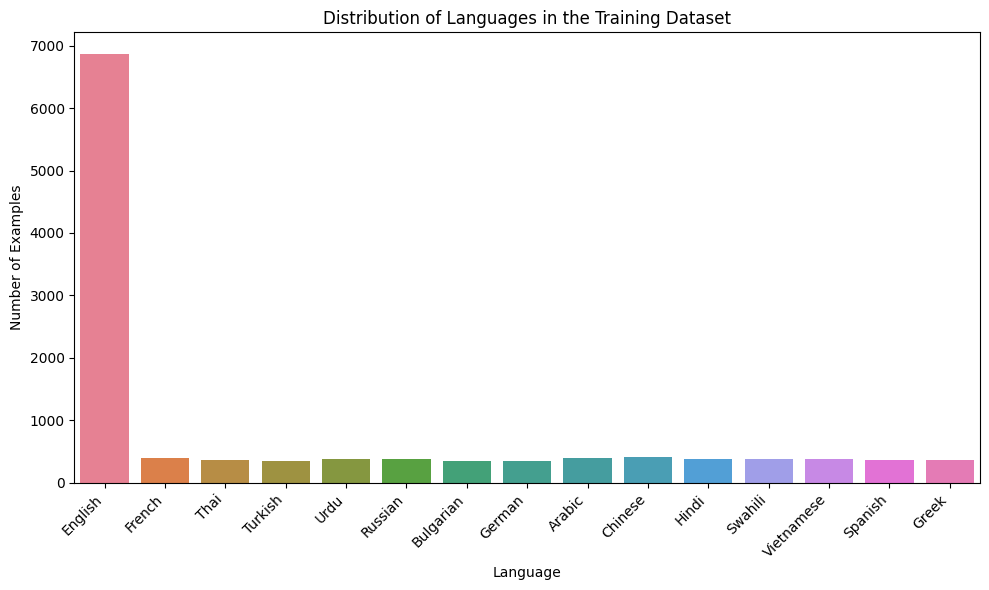

In [6]:
# plot the distribution of languages

plt.figure(figsize=(10, 6))
sns.countplot(x='language', data=train, hue="language")
plt.title('Distribution of Languages in the Training Dataset')
plt.xlabel('Language')
plt.ylabel('Number of Examples')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


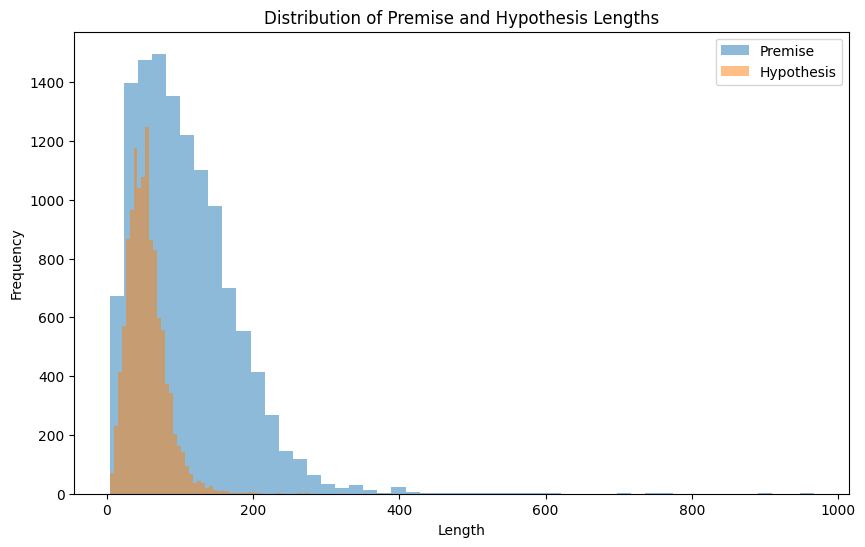

In [7]:
# plot the lengths of premises and hypotheses

plt.figure(figsize=(10, 6))
plt.hist(train['premise'].str.len(), bins=50, alpha=0.5, label='Premise')
plt.hist(train['hypothesis'].str.len(), bins=50, alpha=0.5, label='Hypothesis')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution of Premise and Hypothesis Lengths')
plt.legend(loc='upper right')
plt.show()


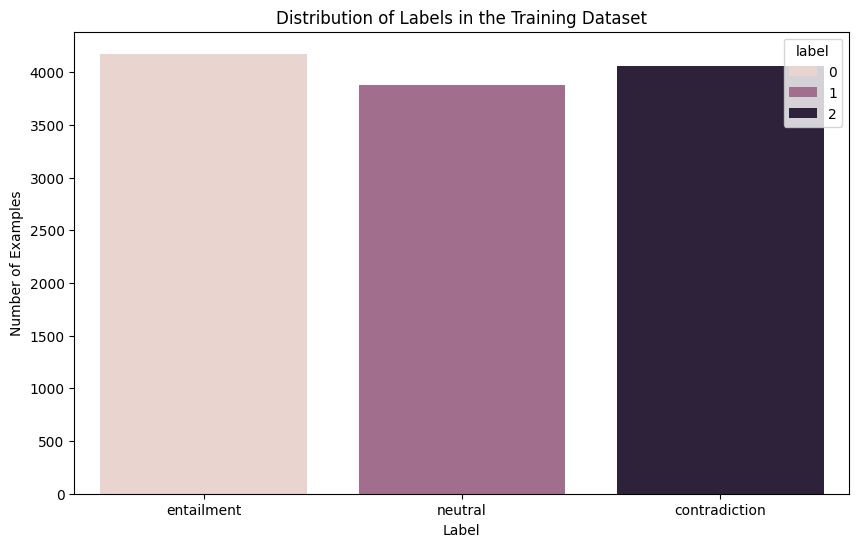

In [8]:
# plot the distribution of labels

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train, hue="label")
plt.title('Distribution of Labels in the Training Dataset')
plt.xlabel('Label')
plt.ylabel('Number of Examples')
plt.xticks(ticks=[0, 1, 2], labels=[ResultCategories[0], ResultCategories[1], ResultCategories[2]])
plt.show()


# Pre-Process Data

## Tokenize Data

In [11]:
# Initialize tokenizer
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize_sentence(premise, hypothesis, tokenizer, max_length=128):
    return tokenizer(
        premise, hypothesis,
        padding="max_length", # maybe change?
        truncation=True,
        max_length=max_length,
        return_tensors="tf",
        return_overflowing_tokens=False  # Avoid warning
    )

# Tokenize data
train_encodings = tokenize_sentence(train['premise'].tolist(), train['hypothesis'].tolist(), tokenizer)
test_encodings = tokenize_sentence(test['premise'].tolist(), test['hypothesis'].tolist(), tokenizer)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

## Convert Data to TensorFlow tensors

In [12]:
# Prep data for model input
import tensorflow as tf

train_inputs = {
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"]
}
test_inputs = {
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"]
}

# Convert labels to TensorFlow tensors
train_labels = tf.convert_to_tensor(train["label"].values)

# Create TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).batch(16)
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs)).batch(16)

# Build Model

Training BERT-based classication model

In [14]:
from tensorflow.keras.optimizers import Adam
from transformers import TFBertForSequenceClassification

optimizer = Adam(learning_rate=2e-5)

# Load model
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=3)  # 3 labels for contradiction, entailment, neutral

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy", "loss"]
model.compile(optimizer="adam", loss=loss, metrics=metrics)

# Train model
history = model.fit(train_dataset, epochs=1) # Update to compute more epochs later

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


758/758 [==============================] - 352s 414ms/step - loss: 1.1364 - accuracy: 0.3325


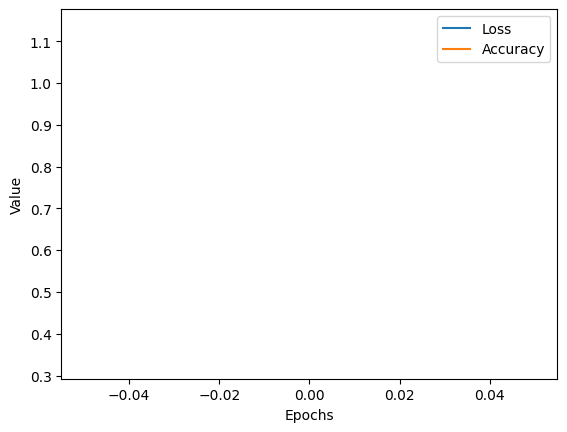

In [15]:
# Visualize loss and accuracy:

import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["accuracy"], label="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

# Evalute the Model

In [16]:
# Eveluate on Training Data
train_loss, train_accuracy = model.evaluate(train_dataset)
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

758/758 [==============================] - 111s 142ms/step - loss: 1.1230 - accuracy: 0.3446
Training Loss: 1.1229556798934937
Training Accuracy: 0.34455445408821106


stopped here


---



In [17]:
# Evaluate on Validation Set
from sklearn.model_selection import train_test_split

# Assuming 'train_inputs' and 'train_labels' are your data and labels
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    train_inputs, train_labels, test_size=0.1, random_state=42
)

# Create TensorFlow datasets
val_dataset = tf.data.Dataset.from_tensor_slices((val_inputs, val_labels)).batch(16)

# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

ValueError: Found input variables with inconsistent numbers of samples: [2, 12120]

# Test Predictions

In [ ]:
# Tokenize test df
test_encodings = tokenize_sentence(
    test['premise'].tolist(), test['hypothesis'].tolist(), tokenizer
)

test_inputs = {
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"]
}

# Create TensorFlow dataset
test_dataset = tf.data.Dataset.from_tensor_slices(test_inputs).batch(16)

In [ ]:
# Predict
import numpy as np

# Predict probabilities
predictions = model.predict(test_dataset)
# Convert logits to class labels
predicted_labels = np.argmax(predictions.logits, axis=1)